In [30]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from time import time
con = create_engine(os.environ['db_uri'], echo=False).raw_connection()

In [86]:
currency = "EUR"
sql = "select date,currency,rate, extract(dow from date) as dow \
       from rates \
       where \
        currency = %(currency)s \
        and date between %(start)s and %(end)s \
       group by 1, 2, 3, 4"
df = pd.read_sql(sql,con,
                 params={'currency':currency,
                         'start':'2015-01-01',
                         'end':'2017-04-20'},index_col='date',parse_dates=['date'])
df['date'] = df.index

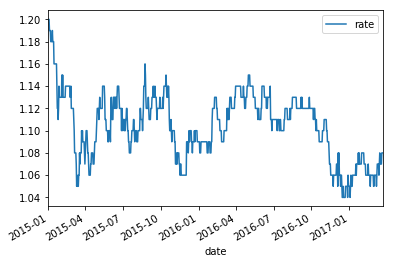

In [87]:
df.plot('date','rate')

In [88]:
df.head()

,currency,rate,dow,date
date,,,,
2016-05-17,EUR,1.13,2.0,2016-05-17
2015-02-09,EUR,1.13,1.0,2015-02-09
2016-07-16,EUR,1.10,6.0,2016-07-16
2015-01-05,EUR,1.19,1.0,2015-01-05
2015-01-26,EUR,1.12,1.0,2015-01-26


In [89]:
df.describe()

,rate,dow
count,814.000000,814.000000
mean,1.104079,3.003686
std,0.029214,2.000304
min,1.040000,0.000000
25%,1.080000,1.000000
50%,1.110000,3.000000
75%,1.120000,5.000000
max,1.200000,6.000000


In [101]:
class dow(BaseEstimator, TransformerMixin):
    def get_feature_names(self):
        return [self.__class__.__name__]
    
    def fit(self, df, y=None):
        return self
    
    def transform(self, df):
        df.dropna()
        return df['dow'].as_matrix()[None].T.astype(np.float)
    
feature_list = [
    ('dow',dow)
]

feat_union = FeatureUnion(transformer_list=feature_list)
x_tr = df['date'] #feat_union.fit(df)
y = df['rate']
model = RandomForestClassifier(n_jobs=2)
model.fit(x_tr,y)

/Users/john.skilbeck/.virtualenvs/fx/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


ValueError: Unknown label type: 'continuous'

In [97]:
list(map(float,df['dow'].as_matrix()[None].T.astype(np.float)))

[2.0,
 1.0,
 6.0,
 1.0,
 1.0,
 6.0,
 3.0,
 6.0,
 3.0,
 2.0,
 1.0,
 6.0,
 4.0,
 4.0,
 0.0,
 4.0,
 3.0,
 1.0,
 3.0,
 3.0,
 4.0,
 1.0,
 4.0,
 2.0,
 3.0,
 2.0,
 4.0,
 1.0,
 2.0,
 0.0,
 6.0,
 6.0,
 2.0,
 5.0,
 0.0,
 0.0,
 5.0,
 6.0,
 4.0,
 1.0,
 2.0,
 2.0,
 4.0,
 3.0,
 0.0,
 2.0,
 0.0,
 2.0,
 1.0,
 2.0,
 1.0,
 6.0,
 3.0,
 4.0,
 3.0,
 5.0,
 2.0,
 4.0,
 5.0,
 5.0,
 3.0,
 3.0,
 4.0,
 3.0,
 1.0,
 0.0,
 1.0,
 1.0,
 3.0,
 2.0,
 0.0,
 3.0,
 6.0,
 3.0,
 3.0,
 5.0,
 4.0,
 3.0,
 4.0,
 2.0,
 1.0,
 1.0,
 6.0,
 5.0,
 0.0,
 6.0,
 0.0,
 3.0,
 5.0,
 5.0,
 5.0,
 6.0,
 2.0,
 4.0,
 4.0,
 3.0,
 5.0,
 3.0,
 0.0,
 5.0,
 4.0,
 6.0,
 3.0,
 3.0,
 3.0,
 3.0,
 4.0,
 2.0,
 6.0,
 5.0,
 3.0,
 3.0,
 5.0,
 3.0,
 0.0,
 2.0,
 6.0,
 0.0,
 1.0,
 3.0,
 2.0,
 1.0,
 5.0,
 5.0,
 6.0,
 6.0,
 1.0,
 2.0,
 0.0,
 1.0,
 6.0,
 3.0,
 2.0,
 0.0,
 0.0,
 2.0,
 5.0,
 4.0,
 2.0,
 0.0,
 0.0,
 2.0,
 4.0,
 0.0,
 3.0,
 6.0,
 6.0,
 0.0,
 5.0,
 0.0,
 6.0,
 6.0,
 2.0,
 4.0,
 2.0,
 0.0,
 3.0,
 1.0,
 5.0,
 5.0,
 1.0,
 2.0,
 4.0,
 4.0,
 0.0,
 4.0,
 5.0